回帰データの学習。

回帰型は、何等かの法則性のあるデータを学習させ、その後特定の値を食わせたときに対応する値を予測させるというもの。

* 入力: 正弦波（ $ sign(x) $  ）
* 中間層: シグモイド関数
* 出力層: 恒等関数
* 損失関数: 二乗和誤差
* 最適化アルゴリズム: 勾配降下法
* バッチサイズ: 1

で実装する。


参考は [前回の記事](https://white-azalea.hatenablog.jp/entry/2021/03/07/200147) でやったやつ。  
二乗和誤差と恒等関数の組み合わせだと、 $ \delta $ の値は

$$
\delta_k = y_k - t_k
$$

で、残りのパラメータは

$$
\partial w_{jk} = y_j \delta_k (重み勾配) \\
\partial b_k = \delta_k (バイアス勾配) \\
\partial y_j = \sum^n_{r=1} \delta_r w_{jr} (一つ上の層の出力勾配)
$$

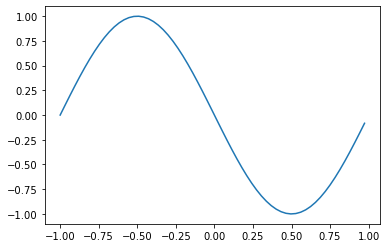

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

wb_width = 0.01 # 重みバイアスの広がり方
epoch    = 2001 # 学習データ数
eta      = 0.1  # 学習係数
interval = 200  # 経過の表示間隔

input_data   = np.arange(0, np.pi * 2, 0.1) # 学習データ
correct_data = np.sin(input_data)           # 正解データ
input_data   = (input_data - np.pi) / np.pi # -1 - 1 にデータを整形
n_data       = len(correct_data)            # データ数

# 各層のニューロン数
n_in  = 1
n_mid = 3
n_out = 1

plt.plot(input_data, correct_data)
plt.show()

In [2]:
class Neuron:
    def __init__(self, n_upper, n, activation_function, differential_function):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
        self.grad_w = np.zeros((n_upper, n))
        self.grad_b = np.zeros((n))
        self.activation_function = activation_function
        self.differential_function = differential_function

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
    
    def forward(self, x):
        self.x = x
        u = x.dot(self.w) + self.b
        self.y = self.activation_function(u)
        return self.y

    def backword(self, t):
        delta = self.differential_function(self.y, t)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x


def identity_func(u):
    """恒等関数"""
    return u


def differential_output(y, t):
    """恒等関数+二乗和誤差の微分"""
    return y - t


class Output(Neuron):
    pass

中間層はシグモイド関数。

こっちはこんな感じ

$$
\delta_j = \partial y_j (1 - y_j)y_j \\
\partial w_{ij} = y_i \delta_j (重み勾配) \\
\partial b_j = \delta_j (バイアス勾配) \\
\partial y_i = \sum^m_{q=1} \delta_q w_{iq} (一つ上の層の出力勾配)
$$

In [3]:
def sigmoid(u):
    """シグモイド関数"""
    return 1 / (1 + np.exp(-u))


def differential_sigmod(grad_y, y):
    """シグモイド関数の微分関数"""
    return grad_y * (1 - y) * y


class Middle(Neuron):
    def backword(self, grad_y):
        delta = self.differential_function(grad_y, self.y)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = delta.sum(axis = 0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x

んじゃま、やってみますか

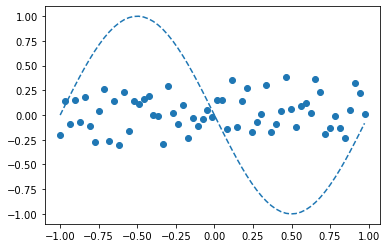

Epoch:0/2001 Error:0.27800230799343


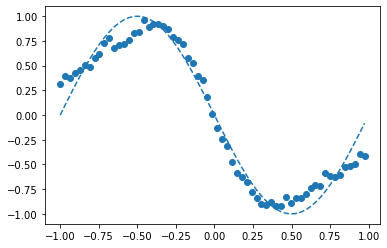

Epoch:200/2001 Error:0.009178591169314278


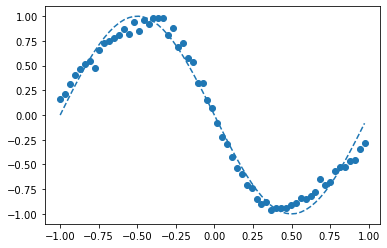

Epoch:400/2001 Error:0.004561613234755241


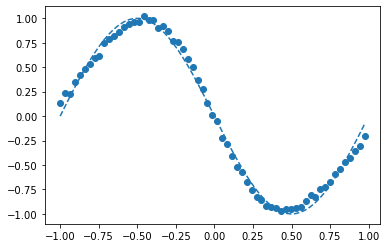

Epoch:600/2001 Error:0.0018697711007538546


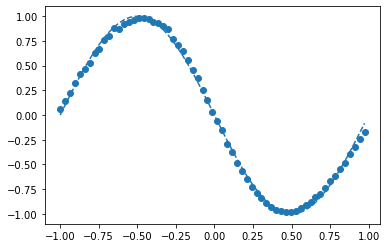

Epoch:800/2001 Error:0.0006030262826247011


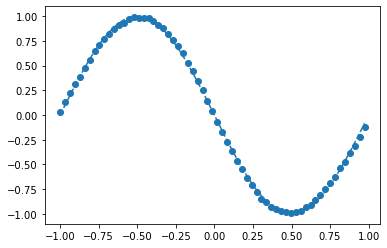

Epoch:1000/2001 Error:0.00017857734190115194


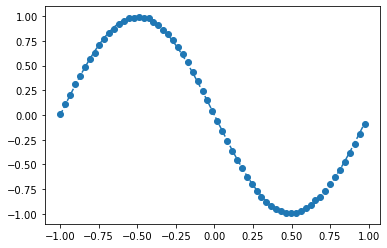

Epoch:1200/2001 Error:6.206869455496167e-05


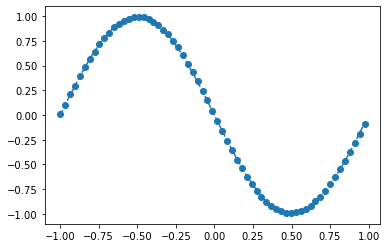

Epoch:1400/2001 Error:2.455124199898678e-05


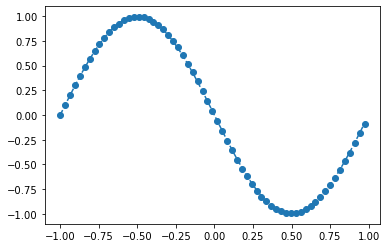

Epoch:1600/2001 Error:1.4314783511039525e-05


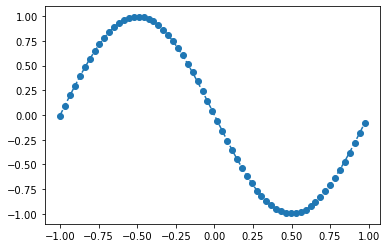

Epoch:1800/2001 Error:8.490760889684467e-06


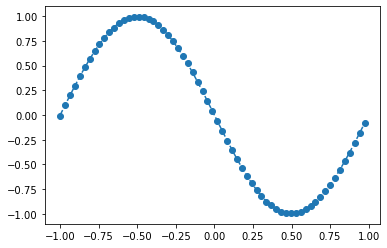

Epoch:2000/2001 Error:7.388875286662434e-06


In [4]:
middle_layer: Middle = Middle(n_in, n_mid, sigmoid, differential_sigmod)
output_layer: Output = Output(n_mid, n_out, identity_func, differential_output)


for i in range(epoch):
    # インデックスシャッフル
    index_random = np.arange(n_data)
    np.random.shuffle(index_random)

    # 学習状況の把握用
    total_err = 0
    plot_x = []
    plot_y = []

    for idx in index_random:
        x = input_data[idx:idx+1]
        t = correct_data[idx:idx+1]

        # 順伝播させて
        output_layer.forward(
            middle_layer.forward(x.reshape(1, 1)))

        # 逆伝播
        middle_layer.backword(
            output_layer.backword(t.reshape(1, 1)))

        # 重み+バイアス更新
        middle_layer.update(eta)
        output_layer.update(eta)

        if i % interval == 0:
            # 行列をベクトルに戻す
            y = output_layer.y.reshape(-1)

            # 二乗和誤差の計算
            total_err += 1.0 / 2.0 * np.sum(np.square(y - t))

            # 出力の記録
            plot_x.append(x)
            plot_y.append(y)
    
    if i % interval == 0:
        # 出力のグラフ表示
        plt.plot(input_data, correct_data, linestyle = 'dashed')
        plt.scatter(plot_x, plot_y, marker='o')
        plt.show()
        print('Epoch:' + str(i) + '/' + str(epoch), 'Error:' + str(total_err / n_data))